Gets self efficacy and response efficacy score

Preprocessing
==============

Efficacy scores were collected in:
- every 3 days evening questionnaires (!! bug in the plateform, question was presented every day for some participants -> need to work out which and take every 3 day measures)

- baseline and followup efficacy - for EEG participants

- screening and followup questionnaire - get scores for online participants

- Participants who did the baseline and followup Efficacy score on the same survey as the every 3 days one: 
562, 477, 703, 786

In [1]:
library(tidyverse)
library(here)
library(lubridate)

#get filepaths

#eff_evening_filepath = here("Every3days")

cond_file = "~/Documents/scripts-local/skyline/BEHAVIOUR/Analysis/expe_condition_final.csv"


save_figure = here::here("Figures")

#read files

files_eff_eve <-dir(path=here::here("data/Every3days") , pattern = "*.csv") 
files_eff_bf <-dir(path=here::here("data/BaselineFollowup") , pattern = "*.csv") 
files_eff_online<-dir(path=here::here("data/OnlineFollowup") , pattern = "*.csv") 
# use here the data from the pp recruitment files
files_eff_base_online<-dir(path=here::here("data/OnlineBaseline") , pattern = "baseline_eff_score.csv") # sheet with screening ID
files_study_id<-dir(path=here::here("data/OnlineBaseline") , pattern = "study_ids_online.csv") # sheet with screening_id/study_ids corresponsdence
files_qualtrics<-dir(path=here::here("data/OnlineBaseline") , pattern = "qualtrics.csv") # sheet with screening_id/study_ids corresponsdence


every3days_scores <-read.csv(here::here("data/Every3days", files_eff_eve), header = TRUE, sep = ",", dec = ".", stringsAsFactors = FALSE)
baseline_followup_eeg <-read.csv(here::here("data/BaselineFollowup", files_eff_bf), header = TRUE, sep = ",", dec = ".", stringsAsFactors = FALSE)
followup_online <-read.csv(here::here("data/OnlineFollowup", files_eff_online), header = TRUE, sep = ",", dec = ".", stringsAsFactors = FALSE)
baseline_online <-read.csv(here::here("data/OnlineBaseline", files_eff_base_online), header = TRUE, sep = ",", dec = ".", stringsAsFactors = FALSE)
study_id <-read.csv(here::here("data/OnlineBaseline",files_study_id), header = TRUE, sep = ",", dec = ".", stringsAsFactors = FALSE)
qualtrics <-read.csv(here::here("data/OnlineBaseline",files_qualtrics), header = TRUE, sep = ",", dec = ".", stringsAsFactors = FALSE)

# condition file
cond <- read_csv(cond_file)


#Associate online pp baseline efficacy score with their study id:


#select only screening ID and qualtrics ID on recruitment file
pp_ids<-baseline_online %>% select("Screening.ID", "Response.ID") 

qualtrics<-rename(qualtrics, Response.ID = ResponseId)


remove(baseline_online)

baseline_online<-left_join(pp_ids, qualtrics, by= 'Response.ID')

# join with study id
baseline_online <- left_join(study_id, baseline_online)

# remove screening id
baseline_online<-select(baseline_online, -Screening.ID)



── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──

✔ ggplot2 3.3.2     ✔ purrr   0.3.4
✔ tibble  3.0.4     ✔ dplyr   1.0.2
✔ tidyr   1.1.2     ✔ stringr 1.4.0
✔ readr   1.4.0     ✔ forcats 0.5.0

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

here() starts at /home/claire/Documents/scripts-local/skyline/BEHAVIOUR/Analysis/Efficacy_scores


Attaching package: ‘lubridate’


The following objects are masked from ‘package:base’:

    date, intersect, setdiff, union



── Column specification ────────────────────────────────────────────────────────
cols(
  `Subject ID` = col_double(),
  day_msg = col_double(),
  `Starting Date` = col_character(),
  Good = col_double(),
  `Condition = Intervention` = col_double(),
  EEG = col_double(),
  Finished = col_double(),
  REMOVED = col_double(),
  Interview = col_double(),
  Notes = col_character(),
  `No Com

In [2]:
#rename columns 
#- questions scoring: 0 = not at all; 100 = very much

every3days_scores<-rename(every3days_scores , date=EndDate, completed=Finished,
                  ID = Q1, 
                  r_eff1 = Q3_1, r_eff2 = Q3_2, 
                  s_eff1= Q4_1, s_eff2 = Q4_2, s_eff3= Q4_3, 
                  hope = Q7_1, 
                  quit_int = Q5
                  )

every3days_scores$ID<-as.factor(every3days_scores$ID)


baseline_followup_eeg <-rename(baseline_followup_eeg, date=EndDate, completed=Finished,
                  ID = Q1, 
                  r_eff1 = Q3_1, r_eff2 = Q3_2, 
                  s_eff1= Q4_1, s_eff2 = Q4_2, s_eff3= Q4_3, 
                  hope = Q7_1
                 # quit_int = Q5
                  )

baseline_followup_eeg$ID<-as.factor(baseline_followup_eeg$ID)


followup_online<-rename(followup_online, date=EndDate, completed=Finished, 
                      ID= Q1, 
                       r_eff1 = Q88_1, r_eff2= Q88_2, 
                       s_eff1 = Q90_1, s_eff2 = Q90_2, s_eff3= Q90_3, 
                       hope=Q92_1
                       )
followup_online$ID<-as.factor(followup_online$ID)

baseline_online<-rename(baseline_online, date=EndDate, completed=Finished, 
                       ID= Study.ID, 
                       r_eff1 = Q108_1, r_eff2= Q108_2, 
                       s_eff1 = Q110_1.1, s_eff2 = Q110_2.1, s_eff3= Q110_3.1, 
                       hope=Q112_1.1
                           )

            
baseline_online$ID<-as.factor(baseline_online$ID)

#Create one long dataset collating all data

# add a "session" column

every3days_scores <- add_column(every3days_scores, "type" = "every3days")
followup_online <- add_column(followup_online, "type" = "followup")
baseline_online<- add_column(baseline_online, "type" = "baseline")

#get sessions for the baseline-followup dataset
  

# remove extra header
#baseline_followup_eeg<-tail(baseline_followup_eeg, -2)

In [3]:
# create session based on occurrence of ID 
baseline_followup_eeg<-baseline_followup_eeg %>% 
        #mutate(date=ymd_hms(baseline_followup_eeg$date))  %>% 
        group_by(ID)  %>%   
        mutate('type'= row_number()) %>% 
        ungroup()
 

In [4]:
       
# assign factor and recode        
baseline_followup_eeg$type<-as.factor(baseline_followup_eeg$type)        
baseline_followup_eeg$type<-recode(baseline_followup_eeg$type, '1'="baseline", '2'="followup")                            


# select only columns of interest

baseline_followup_eeg<-select(baseline_followup_eeg, ID, date, r_eff1:hope, type, completed)
every3days_scores <-select(every3days_scores, ID, date, r_eff1:hope, type, completed)
followup_online<-select(followup_online, ID, date, r_eff1:hope, type, completed)
baseline_online<-select(baseline_online, ID, date, r_eff1:hope, type, completed)

# get only completed surveys
#every3days_scores<-filter(every3days_scores, completed=='True')

#baseline_followup_eeg<-filter(baseline_followup_eeg, completed=='True')
#
#followup_online<-filter(followup_online, completed=='True')
#baseline_online<-filter(baseline_online, completed=='True')

#Do some custom change to fit special cases


#---------------------------------#
# get data for the 4 pps who did the baseline and followup efficacy measure in the every3days

ID_add_to_bf <-c(562, 477, 703, 786)

tmp<- every3days_scores %>% 
  filter(ID %in% ID_add_to_bf)

tmp_bf_score <- tmp %>%  # get baseline and follow up scores - 1st and last 
  group_by(ID) %>% 
  slice(c(1, n())) %>% 
  ungroup()  

baseline_followup_eeg<-full_join(baseline_followup_eeg, tmp_bf_score)  # add to df_bf

# remove first and last measures then put back into main df dataframe, remove these ID from df before !

tmp_df <- tmp %>% 
  group_by(ID) %>% 
  slice(2:(n()-1)) %>% 
  ungroup()  

Joining, by = c("ID", "date", "r_eff1", "r_eff2", "s_eff1", "s_eff2", "s_eff3", "hope", "type", "completed")



In [5]:
# remove those ID from df then put them back

every3days_scores<- every3days_scores %>% 
  filter(!ID %in% ID_add_to_bf )

every3days_scores<-full_join(every3days_scores, tmp_df)

rm(tmp, tmp_bf_score, tmp_df)

Joining, by = c("ID", "date", "r_eff1", "r_eff2", "s_eff1", "s_eff2", "s_eff3", "hope", "type", "completed")



In [6]:
# get IDs of pp who did the survey every day instead of every 3 days

# get date format
every3days_scores$date<-ymd_hms(every3days_scores$date)

Warning message:
“ 2 failed to parse.”


In [7]:
# first remove  false alarms (non completed surveys)

every3days_scores<- every3days_scores %>% filter(every3days_scores$completed=='1')

In [8]:
# add a counter for each row per ID (see 1.)
every3days_scores <- every3days_scores %>% 
  group_by(ID) %>% 
  mutate(n_day = row_number()) %>%
  select(ID, n_day, everything()) %>% 
  ungroup()  
every3days_scores$n_day<-as.factor(every3days_scores$n_day)

In [9]:
get_ID_bug <- every3days_scores %>% 
  group_by(ID) %>% 
  mutate(count = row_number()) %>% 
  filter(count>9) %>% 
  ungroup()  

In [ ]:
# get pp who were in bug window
# get survey completed at start date + 3 +3 etc...

In [11]:
# get the experiment condition file with all pp IDs
cond <-rename(cond, ID = "Subject ID", condition = "Condition = Intervention", removed= "REMOVED")
cond$ID<-as.factor(cond$ID)


every3days_scores_tmp<-full_join(cond, every3days_scores)

Joining, by = "ID"



In [ ]:
# get list of pp who started during bug time window (July/August) 
#ID_bug<-every3days_scores_tmp %>% 
 #           filter(n_day==1) %>% 
 #           filter(date>=as.Date("2019-07-23") & date<=as.Date("2019-08-30") ) 



In [12]:
every3days_scores_tmp <-rename(every3days_scores_tmp , start=`Starting Date`)
every3days_scores_tmp$start<-dmy(every3days_scores_tmp$start)


df_bug<- every3days_scores_tmp %>% 
  filter(start>=as.Date("2019-07-20") & date<=as.Date("2019-08-30")) 


# get unique start dates
all_starts<-unique(df_bug$start)
all_starts



[1] "2019-07-27" "2019-07-25" "2019-07-23" "2019-07-20" "2019-08-10"
[6] "2019-08-09"

In [13]:
# make a loop from n=1 to len(all_starts)
for(n in 1:length(all_starts)){
        # get data for 1st date
        #ndf[n]<-paste("df", n, sep="_")
        # create data frame to store every 3 days and their label
        df_dates= tibble(label_days= 1:9)

        df<-df_bug %>% filter(start==all_starts[n]) 
        # get vector with dates corresponding to start date + every 3 days
        n_dates<-vector() # to store every 3 days dates
        for(i in seq(from=3, to=28, by=3)){
            date<-all_starts[n]+days(i)
            n_dates<-append(n_dates, date)
            }


        df_dates<-add_column(df_dates, date=n_dates)
        df_dates$date<-ymd(df_dates$date)
        df_dates$date<-as.POSIXct(df_dates$date)
        # get corresponding data
        #df<-df %>% filter(as.Date(date) %in% n_dates)
        df$date<-floor_date(df$date, unit="day")

        df<-inner_join(df, df_dates, by="date")

        assign(paste("df", n, sep="_"), df)
    }

In [14]:
df %>% filter(df$date %in% df_dates$date)

ID,day_msg,start,Good,condition,EEG,Finished,removed,Interview,Notes,⋯,date,r_eff1,r_eff2,s_eff1,s_eff2,s_eff3,hope,type,completed,label_days
<fct>,<dbl>,<date>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,⋯,<dttm>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<int>
724,59,2019-08-09,0,1,0,1,NA,NA,NA,⋯,2019-08-12,65,82,76,86,90,53,every3days,1,1
724,59,2019-08-09,0,1,0,1,NA,NA,NA,⋯,2019-08-18,86,91,53,36,84,75,every3days,1,3


In [15]:
  
# for those IDs, only select data from the 1, 6, 9, 12, 15, 18, 21, 24, 27 days, and rename 1:9   
days<-c(1, 6, 9, 12, 15, 18, 21, 24, 27)

# create a new dataframe combining all pps 
df9<- every3days_scores %>% 
  filter(ID %in%get_ID_bug$ID & n_day %in% days) 
  

df9$n_day<-recode_factor(df9$n_day, '1' = "1", '6'="2", '9'="3", '12' ="4", '15'="5", '18'="6", '21'="7", '24'="8", '27'="9")

tmp <- every3days_scores %>% 
filter(!ID %in% (get_ID_bug$ID) )

df9<- rbind(df9, tmp)

In [16]:
# create n_day column for baseline and followup
followup_online <- followup_online %>% mutate(n_day = '10')

baseline_online <- baseline_online %>% mutate(n_day = '0')

baseline_followup_eeg<-baseline_followup_eeg %>% 
    mutate(n_day=ifelse(type=='baseline', '0', '10'))
    

#baseline_online<-filter(baseline_online, completed=='True')

# remove extra every 3 days rows
baseline_followup_eeg<-baseline_followup_eeg %>% 
        filter(type=='baseline'|type=='followup')

# get the date in correct format
baseline_followup_eeg$date<-ymd_hms(baseline_followup_eeg$date)
followup_online$date<-ymd_hms(followup_online$date)
baseline_online$date<-ymd_hms(baseline_online$date)

eff_scores<-bind_rows(baseline_followup_eeg, df9)

tmp<-bind_rows(eff_scores, followup_online) 

tmp2<- bind_rows(tmp, baseline_online)

remove(eff_scores)

Warning message:
“ 2 failed to parse.”
Warning message:
“ 2 failed to parse.”


In [17]:
eff_scores<-tmp2


eff_scores<-tail(eff_scores, -2) # remove extra header
eff_scores$ID<-as.factor(eff_scores$ID)
eff_scores$type<-as.factor(eff_scores$type)

eff_scores %>% 
        group_by(ID)  %>%   
        mutate(check= row_number()) %>% 
        ungroup()
        

ID,date,r_eff1,r_eff2,s_eff1,s_eff2,s_eff3,hope,type,completed,n_day,check
<fct>,<dttm>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<fct>,<chr>,<chr>,<int>
726,2019-10-03 13:18:18,82,40,4,0,41,2,baseline,True,0,1
743,2019-10-08 10:19:47,82,49,4,20,75,5,baseline,True,0,1
763,2019-10-09 11:24:43,100,51,20,20,51,20,baseline,True,0,1
507,2019-10-10 10:29:17,99,100,45,3,11,40,baseline,True,0,1
388,2019-10-10 13:52:45,45,21,11,21,80,34,baseline,True,0,1
428,2019-10-14 10:01:58,60,61,19,2,5,1,baseline,True,0,1
375,2019-10-14 15:20:03,100,50,0,0,30,11,baseline,True,0,1
747,2019-10-16 10:24:59,49,62,18,12,72,41,baseline,True,0,1
477,2019-10-22 11:09:56,100,80,20,1,75,15,baseline,True,0,1


Create one big dataframe assembling all the others

In [18]:
# associate with cond file 
eff_scores$ID<-as.factor(eff_scores$ID)


tmp<-full_join(cond, eff_scores)


remove(eff_scores)
eff_scores<-tmp



#recode condition to human names

eff_scores$condition<-recode(eff_scores$condition, '0' = "control", '1' = "intervention")

Joining, by = "ID"



Filter participants based on survey completion criteria

In [19]:
#Replace missing values and keep only participants who were not removed
eff_scores$removed<-eff_scores$removed %>% replace(is.na(.), 0)

In [20]:
#filter to keep participants not removed
eff_scores<-eff_scores%>%filter(removed == 0)

In [ ]:
# filter to keep participants who did at least 80% of surveys
#eff_scores<-eff_scores%>%filter(Good == 1)

Do a check of for missing values in the data


In [21]:
missing.values <- eff_scores %>%
    gather(key = "key", value = "val") %>%
    mutate(is.missing = is.na(val)) %>%
    group_by(key, is.missing) %>%
    summarise(num.missing = n()) %>%
    filter(is.missing==T) %>%
    select(-is.missing) %>%
    arrange(desc(num.missing)) 

missing.values

Warning message:
“attributes are not identical across measure variables;
they will be dropped”
`summarise()` regrouping output by 'key' (override with `.groups` argument)



key,num.missing
<chr>,<int>
Interview,2018
Email reminder poor perf,1997
No Compliance,1930
Notes,1663
Finished,862
ev3days,105
eve_msg,65
day_msg,61
Starting Date,48


Look at why we have condition with missing values


In [22]:
tmp<-which(is.na(eff_scores$condition))

In [23]:
eff_scores[tmp, ]

ID,day_msg,Starting Date,Good,condition,EEG,Finished,removed,Interview,Notes,⋯,date,r_eff1,r_eff2,s_eff1,s_eff2,s_eff3,hope,type,completed,n_day
<fct>,<dbl>,<chr>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,⋯,<dttm>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<fct>,<chr>,<chr>
0,NA,NA,NA,NA,NA,NA,0,NA,NA,⋯,2019-04-11 09:44:30,52,97,38,43,47,41,every3days,1,1
333,NA,NA,NA,NA,NA,NA,0,NA,NA,⋯,2019-04-13 22:04:55,84,75,80,87,69,84,every3days,1,1
,NA,NA,NA,NA,NA,NA,0,NA,NA,⋯,2019-06-09 22:49:02,80,74,6,8,28,4,every3days,1,1
36q,NA,NA,NA,NA,NA,NA,0,NA,NA,⋯,2019-07-10 23:13:42,76,77,5,8,8,87,every3days,1,1
7367493311,NA,NA,NA,NA,NA,NA,0,NA,NA,⋯,2019-07-29 21:31:12,100,82,51,1,50,0,every3days,1,1
,NA,NA,NA,NA,NA,NA,0,NA,NA,⋯,2019-07-30 22:44:56,51,80,62,42,31,51,every3days,1,2
,NA,NA,NA,NA,NA,NA,0,NA,NA,⋯,2019-08-03 22:39:47,36,51,100,100,100,67,every3days,1,3
0,NA,NA,NA,NA,NA,NA,0,NA,NA,⋯,2019-08-12 09:27:26,83,74,55,47,73,30,every3days,1,2
,NA,NA,NA,NA,NA,NA,0,NA,NA,⋯,2019-09-12 16:26:59,,,,,,,every3days,1,4


Commented lines below: best to remove NA locally when doing an operation rather than totally at the dataframe level

In [ ]:
# remove these lines 
#eff_scores<-drop_na(eff_scores, condition)


In [ ]:
#which(is.na(eff_scores$s_eff1))

In [ ]:
#eff_scores<-drop_na(eff_scores, r_eff1)


In [41]:
df<-eff_scores


 Compute response and self efficacy scores:
--------------------------------------------

get the mean of all individual scores in each condition for each day:

- define days 1-2-3 etc.
- check for those pp who did baseline and followup (IDs 562, 477, 703, 786)
- find participants with a maximum of 9 n_day
- find participants with more than 9 n_day entries
- take only only every 3 days: 1, 6, 9, 12, 15, 18, 21

create new dataset:  
- count how many of each day per condition


In [42]:
# transform the columns for response and self efficacy that were charactuers in numeric tyoe           
df <-df %>% mutate_each(funs(as.numeric), -ID,  -date, -condition, -type) 

Warning message:
“Problem with `mutate()` input `Starting Date`.
ℹ NAs introduced by coercion
ℹ Input `Starting Date` is `as.numeric(`Starting Date`)`.”
Warning message in mask$eval_all_mutate(dots[[i]]):
“NAs introduced by coercion”
Warning message:
“Problem with `mutate()` input `Notes`.
ℹ NAs introduced by coercion
ℹ Input `Notes` is `as.numeric(Notes)`.”
Warning message in mask$eval_all_mutate(dots[[i]]):
“NAs introduced by coercion”
Warning message:
“Problem with `mutate()` input `Email reminder poor perf`.
ℹ NAs introduced by coercion
ℹ Input `Email reminder poor perf` is `as.numeric(`Email reminder poor perf`)`.”
Warning message in mask$eval_all_mutate(dots[[i]]):
“NAs introduced by coercion”
Warning message:
“Problem with `mutate()` input `r_eff1`.
ℹ NAs introduced by coercion
ℹ Input `r_eff1` is `as.numeric(r_eff1)`.”
Warning message in mask$eval_all_mutate(dots[[i]]):
“NAs introduced by coercion”
Warning message:
“Problem with `mutate()` input `r_eff2`.
ℹ NAs introduced by co

In [43]:
df<-select(df, -'removed', -'Finished', -'Interview', -'Notes', -"completed" )

In [45]:
df<-select(df, -'Starting Date', -'day_msg',  -'No Compliance', -'Email reminder poor perf', -'eve_msg', -'ev3days')

In [46]:
colnames(df)

[1] "ID"        "Good"      "condition" "EEG"       "date"      "r_eff1"   
 [7] "r_eff2"    "s_eff1"    "s_eff2"    "s_eff3"    "hope"      "type"     
[13] "n_day"

In [47]:
# pass n_days as factor and recode day 0 and 10
df$n_day<-as.factor(df$n_day)

df$n_day<-recode(df$n_day, '0'= 'baseline', '10'='follow-up' )

In [86]:
# count number of participants in each condition
df<-df %>% group_by(condition) %>% 
mutate(n_pp=n_distinct(ID)) %>% 
    ungroup()

df<-df %>% group_by(condition, EEG) %>% 
mutate(n_pp_eeg=n_distinct(ID)) %>% 
    ungroup()


# First Plot some data 

count how many of each day per condition

To DO 
!!! Warning: check that the count is actually correct!!!

In [78]:
# count how many of each day per condition (ie.did the pp completed the survey)

n_rep <- df %>% group_by(condition, n_day) %>%
 mutate(count=n()) %>% 
    ungroup()
n_rep <-n_rep %>% drop_na()

Saving 6.67 x 6.67 in image



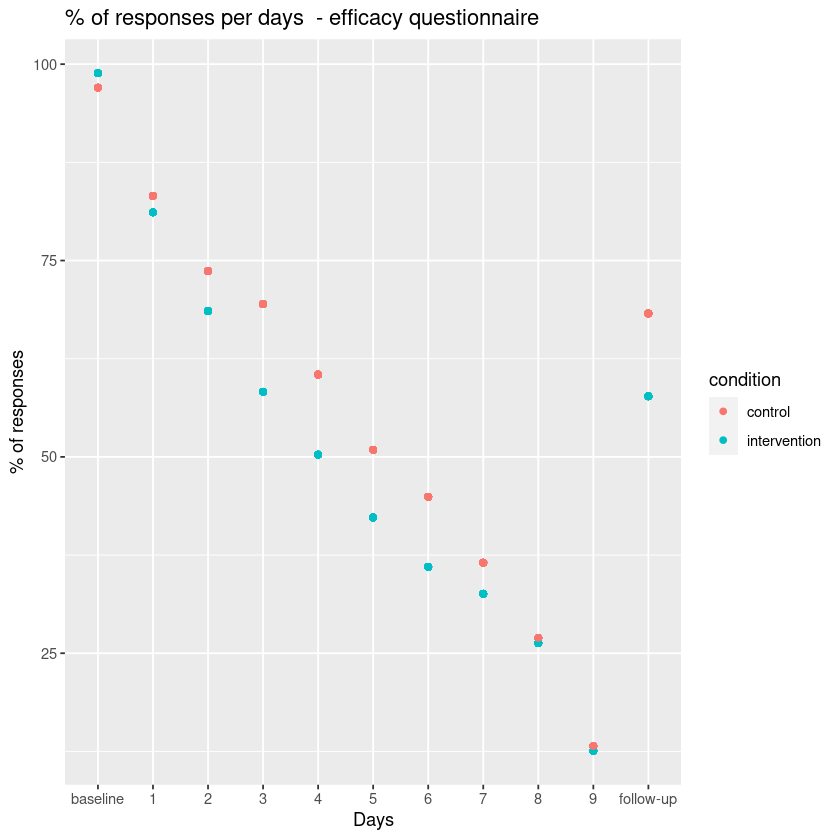

In [81]:
# plot
ggplot(data= n_rep, aes(x = n_day, y=count/n_pp*100)) +
  geom_point(mapping = aes(colour = condition) ) +
  ggtitle("% of responses per days  - efficacy questionnaire")+
  xlab('Days')+ ylab('% of responses')+ 
 ggsave('percent_resp_per_day.jpg', plot =last_plot(), dpi =300, path= save_figure)
 

In [95]:
# count how many of each day per condition and EEG
n_rep <- df %>% group_by(n_day, condition, EEG) %>%
  mutate(count=n()) %>% 
    ungroup()
n_rep <-n_rep %>% drop_na()

Saving 6.67 x 6.67 in image



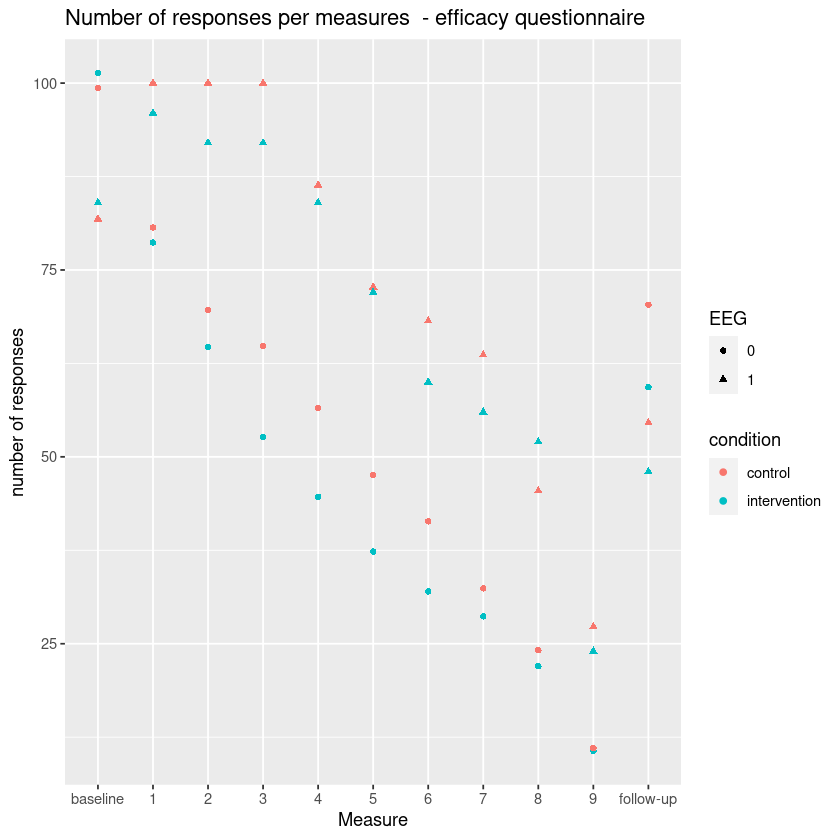

In [91]:
n_rep$EEG<-as.factor(n_rep$EEG)


# plot
ggplot(data= n_rep, aes(x = n_day, y=count/n_pp_eeg*100)) +
  geom_point(mapping = aes(colour = condition, shape =EEG ) ) +
  ggtitle("Number of responses per measures  - efficacy questionnaire")+
  xlab('Measure')+ ylab('number of responses')+ 
 ggsave('nresp_per_day_eeg.jpg', plot =last_plot(), dpi =300, path= save_figure)
 

## Model scores for self, response and hope


We will proceed to visual inspections of the residuals to ensure our data does not deviate from homoscedasticity and normality. P-values will be obtained by likelihood ratio test of the full model with the effect of “condition” against the model without the effect of “condition”. In summary here are the model equations that we will use:


- model 1: SE ~time + condition +(1+ time|subject) 
- model 2: RE~time + condition + (1+time|subject)
- model 1 null: SE~time + (1+time|subject)
- model 2 null: RE~time +(1+time|subject)

From chat with Osama:
- use mice to impute missing data
- if including baseline and followup days create 2 time lag variables between baseline and day1 and day 28 and follow up:

 RE ~ time + timelag + timelag_fwup + condition + (1 + time|subject) 

then see if these timelag variables have an effect on the model and if not, drop them


In [99]:
library(mice)
library (lme4)


Attaching package: ‘mice’


The following object is masked from ‘package:stats’:

    filter


The following objects are masked from ‘package:base’:

    cbind, rbind


Loading required package: Matrix


Attaching package: ‘Matrix’


The following objects are masked from ‘package:tidyr’:

    expand, pack, unpack




In [ ]:
colnames(df)

In [97]:
# take the score of each (resp and self) item for each day for each pp

df<- df %>% 
         mutate(score_re= rowMeans(select(., c('r_eff1','r_eff2')), na.rm=TRUE) , 
         score_se= rowMeans(select(., c('s_eff1', 's_eff2', 's_eff3')), na.rm=TRUE), 
         score_hope= rowMeans(select(., c('hope')), na.rm=TRUE)        
         ) 
    

### Response efficacy

`geom_smooth()` using formula 'y ~ x'

Warning message:
“Removed 235 rows containing non-finite values (stat_smooth).”
Warning message in simpleLoess(y, x, w, span, degree = degree, parametric = parametric, :
“pseudoinverse used at 1.97”
Warning message in simpleLoess(y, x, w, span, degree = degree, parametric = parametric, :
“neighborhood radius 1.03”
Warning message in simpleLoess(y, x, w, span, degree = degree, parametric = parametric, :
“reciprocal condition number  0”
Warning message in simpleLoess(y, x, w, span, degree = degree, parametric = parametric, :
“There are other near singularities as well. 1”
Warning message in predLoess(object$y, object$x, newx = if (is.null(newdata)) object$x else if (is.data.frame(newdata)) as.matrix(model.frame(delete.response(terms(object)), :
“pseudoinverse used at 1.97”
Warning message in predLoess(object$y, object$x, newx = if (is.null(newdata)) object$x else if (is.data.frame(newdata)) as.matrix(model.frame(delete.response(terms(object)), :
“ne

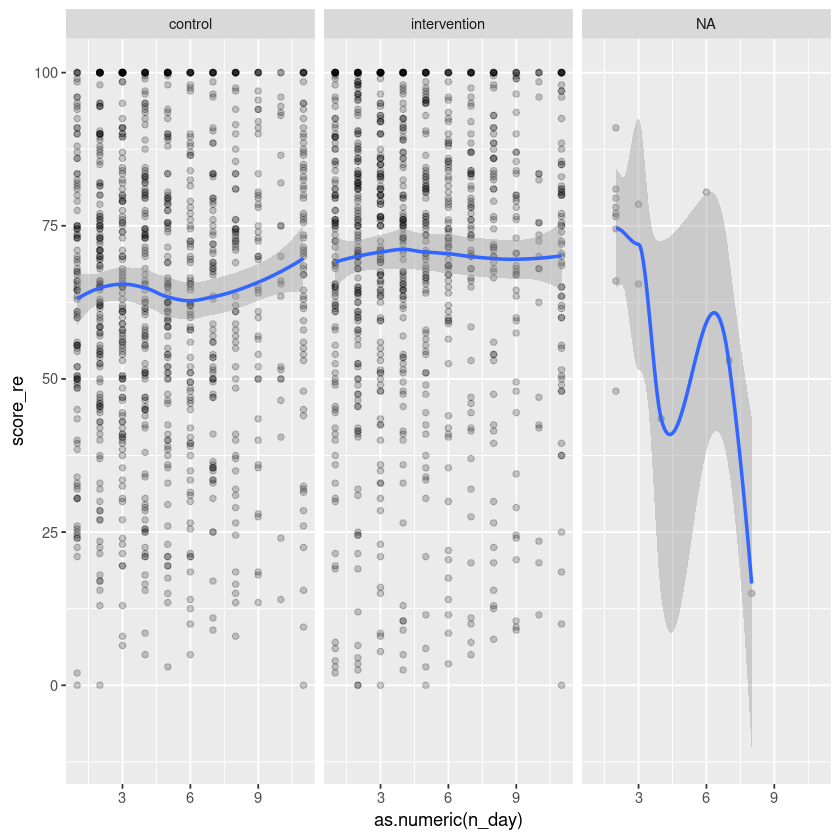

In [100]:
df %>% ggplot(aes(y = score_re, x = as.numeric(n_day)))+
geom_point(alpha = 0.2)+
geom_smooth(method = "loess")+
facet_grid(~condition)

In [109]:
df_re<-select(df, ID, n_day, condition, score_re)

,ID,n_day,date,condition,score_re,
1815,1,1,1,1,1,0
211,1,1,1,1,0,1
15,1,1,1,0,1,1
14,1,1,1,0,0,2
5,1,1,0,1,0,2
5,1,1,0,0,0,3
,0,0,10,34,235,279


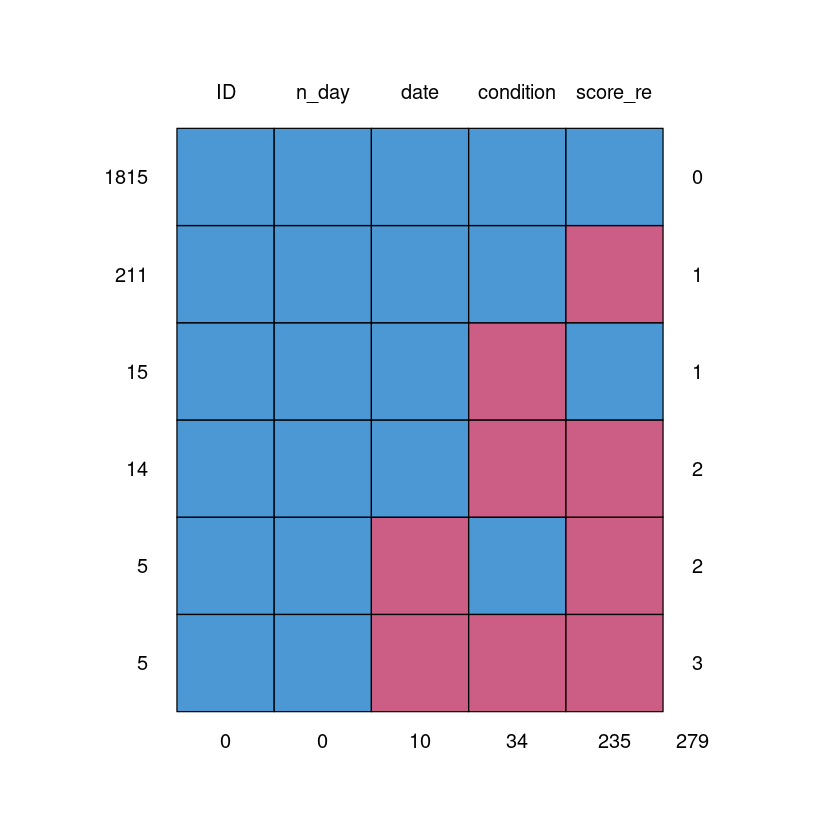

In [107]:
# impute missing data

md.pattern(df_re)

In [110]:
imp<- mice(df_re, maxit=2, m=2)


 iter imp variable
  1   1  score_re
  1   2  score_re
  2   1  score_re
  2   2  score_re


Warning message:
“Number of logged events: 5”


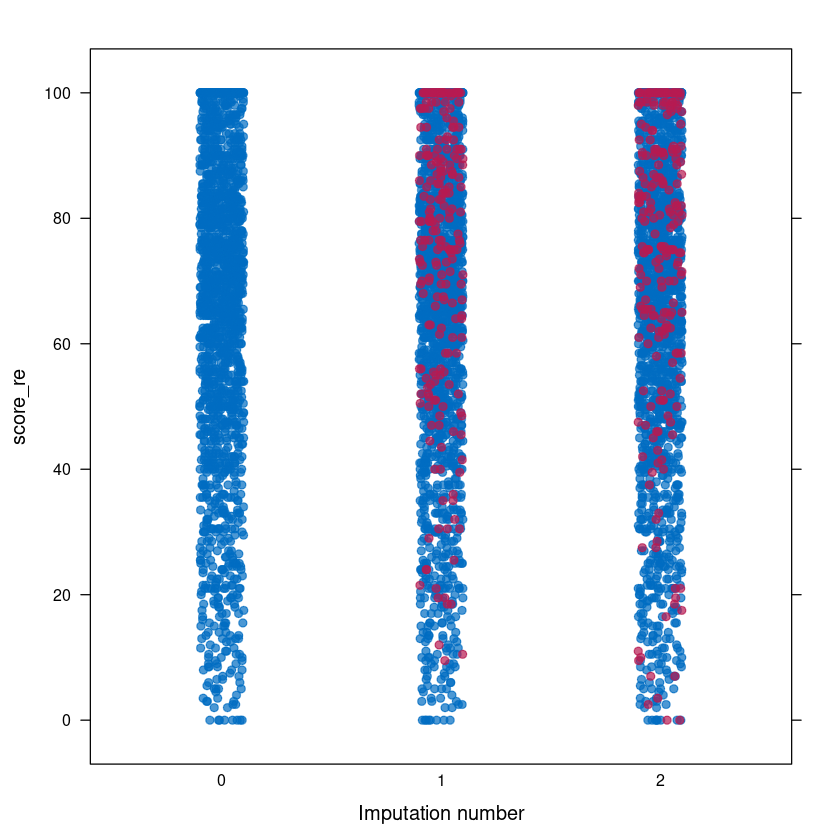

In [111]:
# inspect quality of imputations
stripplot(imp, score_re, pch = 19, xlab = "Imputation number")

In [113]:
fit<- with(imp, lmer(score_re~n_day + condition +(1 + n_day|ID)))


ERROR: Error: number of observations (=2031) <= number of random effects (=3762) for term (n_day | ID); the random-effects parameters and the residual variance (or scale parameter) are probably unidentifiable


### Self Efficacy

`geom_smooth()` using formula 'y ~ x'

Warning message:
“Removed 235 rows containing non-finite values (stat_smooth).”
Warning message in simpleLoess(y, x, w, span, degree = degree, parametric = parametric, :
“pseudoinverse used at 1.97”
Warning message in simpleLoess(y, x, w, span, degree = degree, parametric = parametric, :
“neighborhood radius 1.03”
Warning message in simpleLoess(y, x, w, span, degree = degree, parametric = parametric, :
“reciprocal condition number  0”
Warning message in simpleLoess(y, x, w, span, degree = degree, parametric = parametric, :
“There are other near singularities as well. 1”
Warning message in predLoess(object$y, object$x, newx = if (is.null(newdata)) object$x else if (is.data.frame(newdata)) as.matrix(model.frame(delete.response(terms(object)), :
“pseudoinverse used at 1.97”
Warning message in predLoess(object$y, object$x, newx = if (is.null(newdata)) object$x else if (is.data.frame(newdata)) as.matrix(model.frame(delete.response(terms(object)), :
“ne

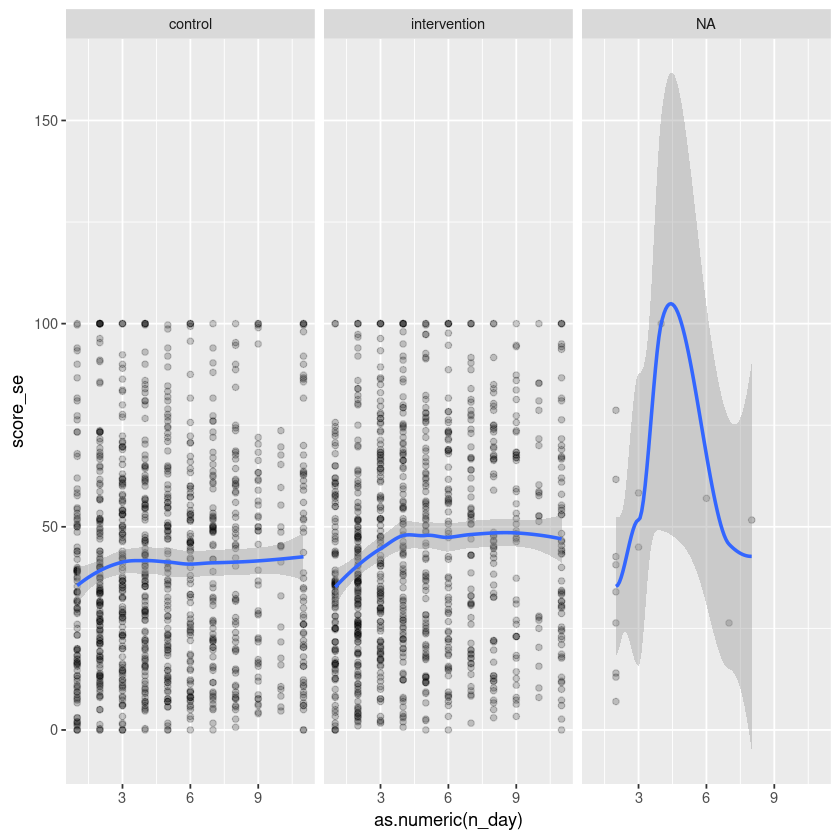

In [101]:
df %>% ggplot(aes(y = score_se, x = as.numeric(n_day)))+
geom_point(alpha = 0.2)+
geom_smooth(method = "loess")+
facet_grid(~condition)

### Hope

`geom_smooth()` using formula 'y ~ x'

Warning message:
“Removed 236 rows containing non-finite values (stat_smooth).”
Warning message in simpleLoess(y, x, w, span, degree = degree, parametric = parametric, :
“pseudoinverse used at 1.97”
Warning message in simpleLoess(y, x, w, span, degree = degree, parametric = parametric, :
“neighborhood radius 1.03”
Warning message in simpleLoess(y, x, w, span, degree = degree, parametric = parametric, :
“reciprocal condition number  0”
Warning message in simpleLoess(y, x, w, span, degree = degree, parametric = parametric, :
“There are other near singularities as well. 1”
Warning message in predLoess(object$y, object$x, newx = if (is.null(newdata)) object$x else if (is.data.frame(newdata)) as.matrix(model.frame(delete.response(terms(object)), :
“pseudoinverse used at 1.97”
Warning message in predLoess(object$y, object$x, newx = if (is.null(newdata)) object$x else if (is.data.frame(newdata)) as.matrix(model.frame(delete.response(terms(object)), :
“ne

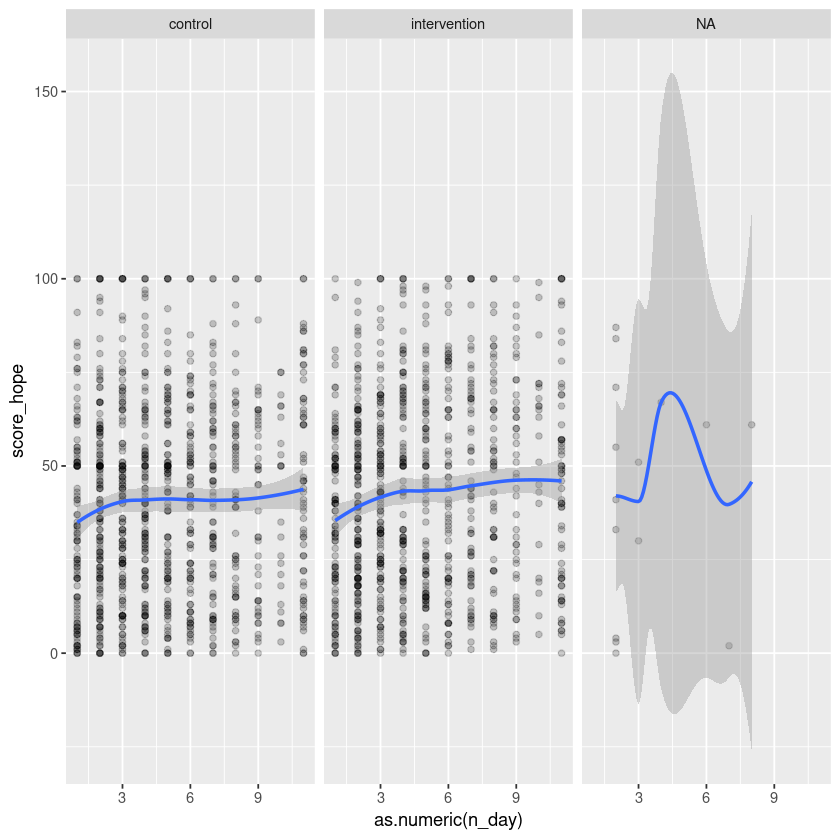

In [102]:
df %>% ggplot(aes(y = score_hope, x = as.numeric(n_day)))+
geom_point(alpha = 0.2)+
geom_smooth(method = "loess")+
facet_grid(~condition)

In [50]:
df2<-select(df, -"r_eff1", -"r_eff2", -"s_eff1", -"s_eff2", -"s_eff3", -"hope")

In [ ]:
#df2<- rename(df2, total_hope=hope)

In [ ]:
#df2<-select(df2, -'Good', -'EEG', -'date')

In [ ]:
head(df2)

In [51]:
# turn df into long format 
df2_long<-df2 %>% 
  pivot_longer(
    -c('ID', 'condition','type', 'n_day', 'Good', 'EEG', 'date'),  
    names_to = c(".value", "value"), 
    names_sep = "_", 
    values_drop_na = TRUE
  )

In [52]:
df2_long$EEG<-as.factor(df2_long$EEG)

In [53]:
# compute summary statistics per condition per day for each score
summary_df2 <- df2_long %>%
  group_by(condition, n_day, value) %>%
  summarise(mean.score = mean(score),
            sd.score= sd(score), count = n(),
            se.mean = sd.score/sqrt(count), 
            ci.mean= qt(1-(1-0.95/2),count-1)*se.mean)

Warning message in qt(1 - (1 - 0.95/2), count - 1):
“NaNs produced”
Warning message in qt(1 - (1 - 0.95/2), count - 1):
“NaNs produced”
Warning message in qt(1 - (1 - 0.95/2), count - 1):
“NaNs produced”
Warning message in qt(1 - (1 - 0.95/2), count - 1):
“NaNs produced”
Warning message in qt(1 - (1 - 0.95/2), count - 1):
“NaNs produced”
Warning message in qt(1 - (1 - 0.95/2), count - 1):
“NaNs produced”
Warning message in qt(1 - (1 - 0.95/2), count - 1):
“NaNs produced”
Warning message in qt(1 - (1 - 0.95/2), count - 1):
“NaNs produced”
Warning message in qt(1 - (1 - 0.95/2), count - 1):
“NaNs produced”
Warning message in qt(1 - (1 - 0.95/2), count - 1):
“NaNs produced”
Warning message in qt(1 - (1 - 0.95/2), count - 1):
“NaNs produced”
Warning message in qt(1 - (1 - 0.95/2), count - 1):
“NaNs produced”
`summarise()` regrouping output by 'condition', 'n_day' (override with `.groups` argument)



In [54]:
summary_df2  %>% filter(n_day == 'baseline')

condition,n_day,value,mean.score,sd.score,count,se.mean,ci.mean
<chr>,<fct>,<chr>,<dbl>,<dbl>,<int>,<dbl>,<dbl>
control,baseline,hope,34.20388,25.45175,103,2.507835,-0.1576457
control,baseline,re,62.77670,23.32515,103,2.298295,-0.1444737
control,baseline,se,35.05987,25.29314,103,2.492207,-0.1566633
intervention,baseline,hope,35.85714,22.67133,105,2.212495,-0.1390736
intervention,baseline,re,69.22381,25.15032,105,2.454419,-0.1542806
intervention,baseline,se,36.35238,21.95712,105,2.142795,-0.1346924


In [55]:
head(summary_df2)

condition,n_day,value,mean.score,sd.score,count,se.mean,ci.mean
<chr>,<fct>,<chr>,<dbl>,<dbl>,<int>,<dbl>,<dbl>
control,baseline,hope,34.20388,25.45175,103,2.507835,-0.1576457
control,baseline,re,62.77670,23.32515,103,2.298295,-0.1444737
control,baseline,se,35.05987,25.29314,103,2.492207,-0.1566633
control,1,hope,39.68345,25.50221,139,2.163069,-0.1358860
control,1,re,65.22662,23.06255,139,1.956140,-0.1228865
control,1,se,40.13669,25.83968,139,2.191693,-0.1376842



- 3. Compute mean response and self efficacy score for each day for each pp

- 4. plot
!!! different number of data points per paricipant !!!

# test plot

https://stackoverflow.com/questions/55262229/how-to-use-geom-errorbar-with-facet-wrap-in-ggplot2

In [ ]:
#write_csv(m_scores, "summary_stats.csv")

Plot response and self efficacy scores

In [ ]:
test_eff<-summary_df2 %>% 
        filter(value=="re" | value=="se") 

In [ ]:
gs1 <- ggplot(test_eff, aes(x=n_day, y=mean.score)) + 
       geom_point(mapping = aes(colour=condition, size=count), alpha=1/3)+ 
       facet_wrap(~value)+
       geom_errorbar(aes(ymin = mean.score - ci.mean, ymax = mean.score + ci.mean), 
                width=0.2)+
    
        #geom_smooth(method=lm, se=FALSE, fullrange=TRUE)+
  xlab("Measures")+ylab("Mean score")+
    ggtitle("Mean scores for response and self efficacy per day per condition,\n reported every 3 days and at baseline and followup")
gs1 + theme(panel.spacing.x=unit(2, "cm"),panel.spacing.y=unit(1, "lines")) +
 theme(axis.text.x = element_text(angle = 90, hjust = 1))
ggsave('efficacy_scores.jpg', plot =last_plot(), dpi =300, path= save_figure)

Seems like scores were quite high to start with for response efficacy, maybe a plateau effect while self efficacy scores were lower at baseline

Plot hope score

In [ ]:
test_hope<-summary_df2 %>% 
        filter(value=="hope")  

In [ ]:
test_hope

In [ ]:

ggplot(data=test_hope, mapping=aes(x= n_day, y=mean.score)) +
      geom_point(mapping = aes(colour=condition, size=count), alpha=1/3)+ 
       geom_errorbar(aes(ymin = mean.score - ci.mean, ymax = mean.score + ci.mean), 
                width=0.2)+
    
        #geom_smooth(method=lm, se=FALSE, fullrange=TRUE)+
  xlab("Measures")+ylab("Mean score")+
   ggtitle("Mean scores for how hopeful about quitting smoking")

  ggsave('hope_scores_v2.jpg', plot =last_plot(), dpi =300, path= save_figure)


Make raincloud plots

In [ ]:
library(cowplot)
library(readr)

source("~/Documents/RainCloudPlots/tutorial_R/R_rainclouds.R")
source("~/Documents/RainCloudPlots/tutorial_R/summarySE.R")

theme_set(theme_cowplot())

In [ ]:
packages <- c("ggplot2", "dplyr", "lavaan", "plyr", "cowplot", "rmarkdown",
"readr", "caTools", "bitops")
if (length(setdiff(packages, rownames(installed.packages()))) > 0) {
install.packages(setdiff(packages, rownames(installed.packages())))
}

In [ ]:
df3<-df2

In [ ]:
which(is.na(df3$n_day))

In [ ]:
colnames(df3)

In [ ]:
df3<-drop_na(df3, n_day)

In [ ]:
 ggplot(df3, aes(x = n_day, y = score_se, fill = condition)) +
  geom_flat_violin(aes(fill = condition),position = position_nudge(x = .1, y = 0), adjust = 1.5, trim = FALSE, alpha = .5, colour = NA)+
  geom_point(aes(x = as.numeric(n_day)-.15, y = score_se, colour = condition),position = position_jitter(width = .05), size = .25, shape = 20)+
  geom_boxplot(aes(x = n_day, y = score_se,  fill = condition),outlier.shape = NA, alpha = .5, width = .1, colour = "black")+
 # geom_line(data = sumrepdat, aes(x = as.numeric(condition)+.1, y = score_mean, group = time, colour = time), linetype = 3)+
 # geom_point(data = sumrepdat, aes(x = as.numeric(group)+.1, y = score_mean, group = time, colour = time), shape = 18) +
 # geom_errorbar(data = sumrepdat, aes(x = as.numeric(group)+.1, y = score_mean, group = time, colour = time, ymin = score_mean-se, ymax = score_mean+se), width = .05)+
  scale_colour_brewer(palette = "Dark2")+
  scale_fill_brewer(palette = "Dark2")+
  xlab('Measure') + ylab('Score')+
  ggtitle("Self-efficacy score") +
  coord_flip()

ggsave('raincloud_self_eff_scores.jpg', plot =last_plot(), dpi =300, path= save_figure)


In [ ]:
ggplot(df3, aes(x = n_day, y = score_re, fill = condition)) +
  geom_flat_violin(aes(fill = condition),position = position_nudge(x = .1, y = 0), adjust = 1.5, trim = FALSE, alpha = .5, colour = NA)+
  geom_point(aes(x = as.numeric(n_day)-.15, y = score_re, colour = condition),position = position_jitter(width = .05), size = .25, shape = 20)+
  geom_boxplot(aes(x = n_day, y = score_re,  fill = condition),outlier.shape = NA, alpha = .5, width = .1, colour = "black")+
 # geom_line(data = sumrepdat, aes(x = as.numeric(condition)+.1, y = score_mean, group = time, colour = time), linetype = 3)+
 # geom_point(data = sumrepdat, aes(x = as.numeric(group)+.1, y = score_mean, group = time, colour = time), shape = 18) +
 # geom_errorbar(data = sumrepdat, aes(x = as.numeric(group)+.1, y = score_mean, group = time, colour = time, ymin = score_mean-se, ymax = score_mean+se), width = .05)+
  scale_colour_brewer(palette = "Dark2")+
  #scale_colour_manual(values=cbPalette)+
  #scale_fill_manual(values=cbPalette)+
  scale_fill_brewer(palette = "Dark2")+
  xlab('Measure') + ylab('Score')+
  ggtitle("Response-efficacy score") +
  coord_flip()

ggsave('raincloud_resp_eff_scores.jpg', plot =last_plot(), dpi =300, path= save_figure)


In [ ]:
ggplot(df3, aes(x = n_day, y = score_hope, fill = condition)) +
  geom_flat_violin(aes(fill = condition),position = position_nudge(x = .1, y = 0), adjust = 1.5, trim = FALSE, alpha = .5, colour = NA)+
  geom_point(aes(x = as.numeric(n_day)-.15, y = score_hope, colour = condition),position = position_jitter(width = .05), size = .25, shape = 20)+
  geom_boxplot(aes(x = n_day, y = score_hope,  fill = condition),outlier.shape = NA, alpha = .5, width = .1, colour = "black")+
 # geom_line(data = sumrepdat, aes(x = as.numeric(condition)+.1, y = score_mean, group = time, colour = time), linetype = 3)+
 # geom_point(data = sumrepdat, aes(x = as.numeric(group)+.1, y = score_mean, group = time, colour = time), shape = 18) +
 # geom_errorbar(data = sumrepdat, aes(x = as.numeric(group)+.1, y = score_mean, group = time, colour = time, ymin = score_mean-se, ymax = score_mean+se), width = .05)+
  scale_colour_brewer(palette = "Dark2")+
  scale_fill_brewer(palette = "Dark2")+
  xlab('Measure') + ylab('Score')+
  ggtitle("Hope score") +
  coord_flip()

ggsave('raincloud_hope_scores.jpg', plot =last_plot(), dpi =300, path= save_figure)


In [ ]:
colnames(df3)